In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import graphviz

# Setting up data and loading model

In [3]:
data = pd.read_csv('FReD-2024-11-29_cleaned.csv')

data = data[data.result != 'OS not significant']
data.loc[data.result == 'Failure (reversal)', 'result'] = 'Failure'

data = data.drop(columns=data.columns[data.columns.str.startswith('tag_')])
data = data.drop(columns=data.columns[data.columns.str.startswith('disc_')])

X = data.drop(columns=['result'])
y = data['result']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [4]:
lgbm_model = lgb.Booster(model_file='models/lgbm_0.76_notags.txt')

In [5]:
preds = lgbm_model.predict(X_test)

In [8]:
pred_labels = preds.round().astype(int)

# Metrics

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score, recall_score, log_loss, confusion_matrix

In [10]:
accuracy_score(y_test, pred_labels)

0.7623762376237624

In [11]:
f1_score(y_test, pred_labels)

0.7551020408163265

In [12]:
precision_score(y_test, pred_labels)

0.7872340425531915

In [13]:
roc_auc_score(y_test, preds)

0.7637254901960784

In [14]:
recall_score(y_test, pred_labels)

0.7254901960784313

In [15]:
log_loss(y_test, preds)

0.5899572412132598

# Plots

## Confusion matrix

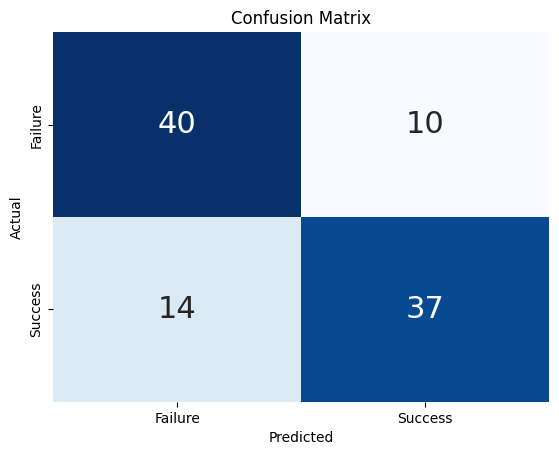

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = le.classes_
confusion_mat = confusion_matrix(y_test, pred_labels)

df_confusion = pd.DataFrame(confusion_mat, index=class_labels, columns=class_labels)

sns.heatmap(
    df_confusion, annot=True, fmt="d", cmap="Blues", cbar=False, 
    annot_kws={"size": 22} #Larger font size for the numbers
    )
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Model Architecture

### Whole model

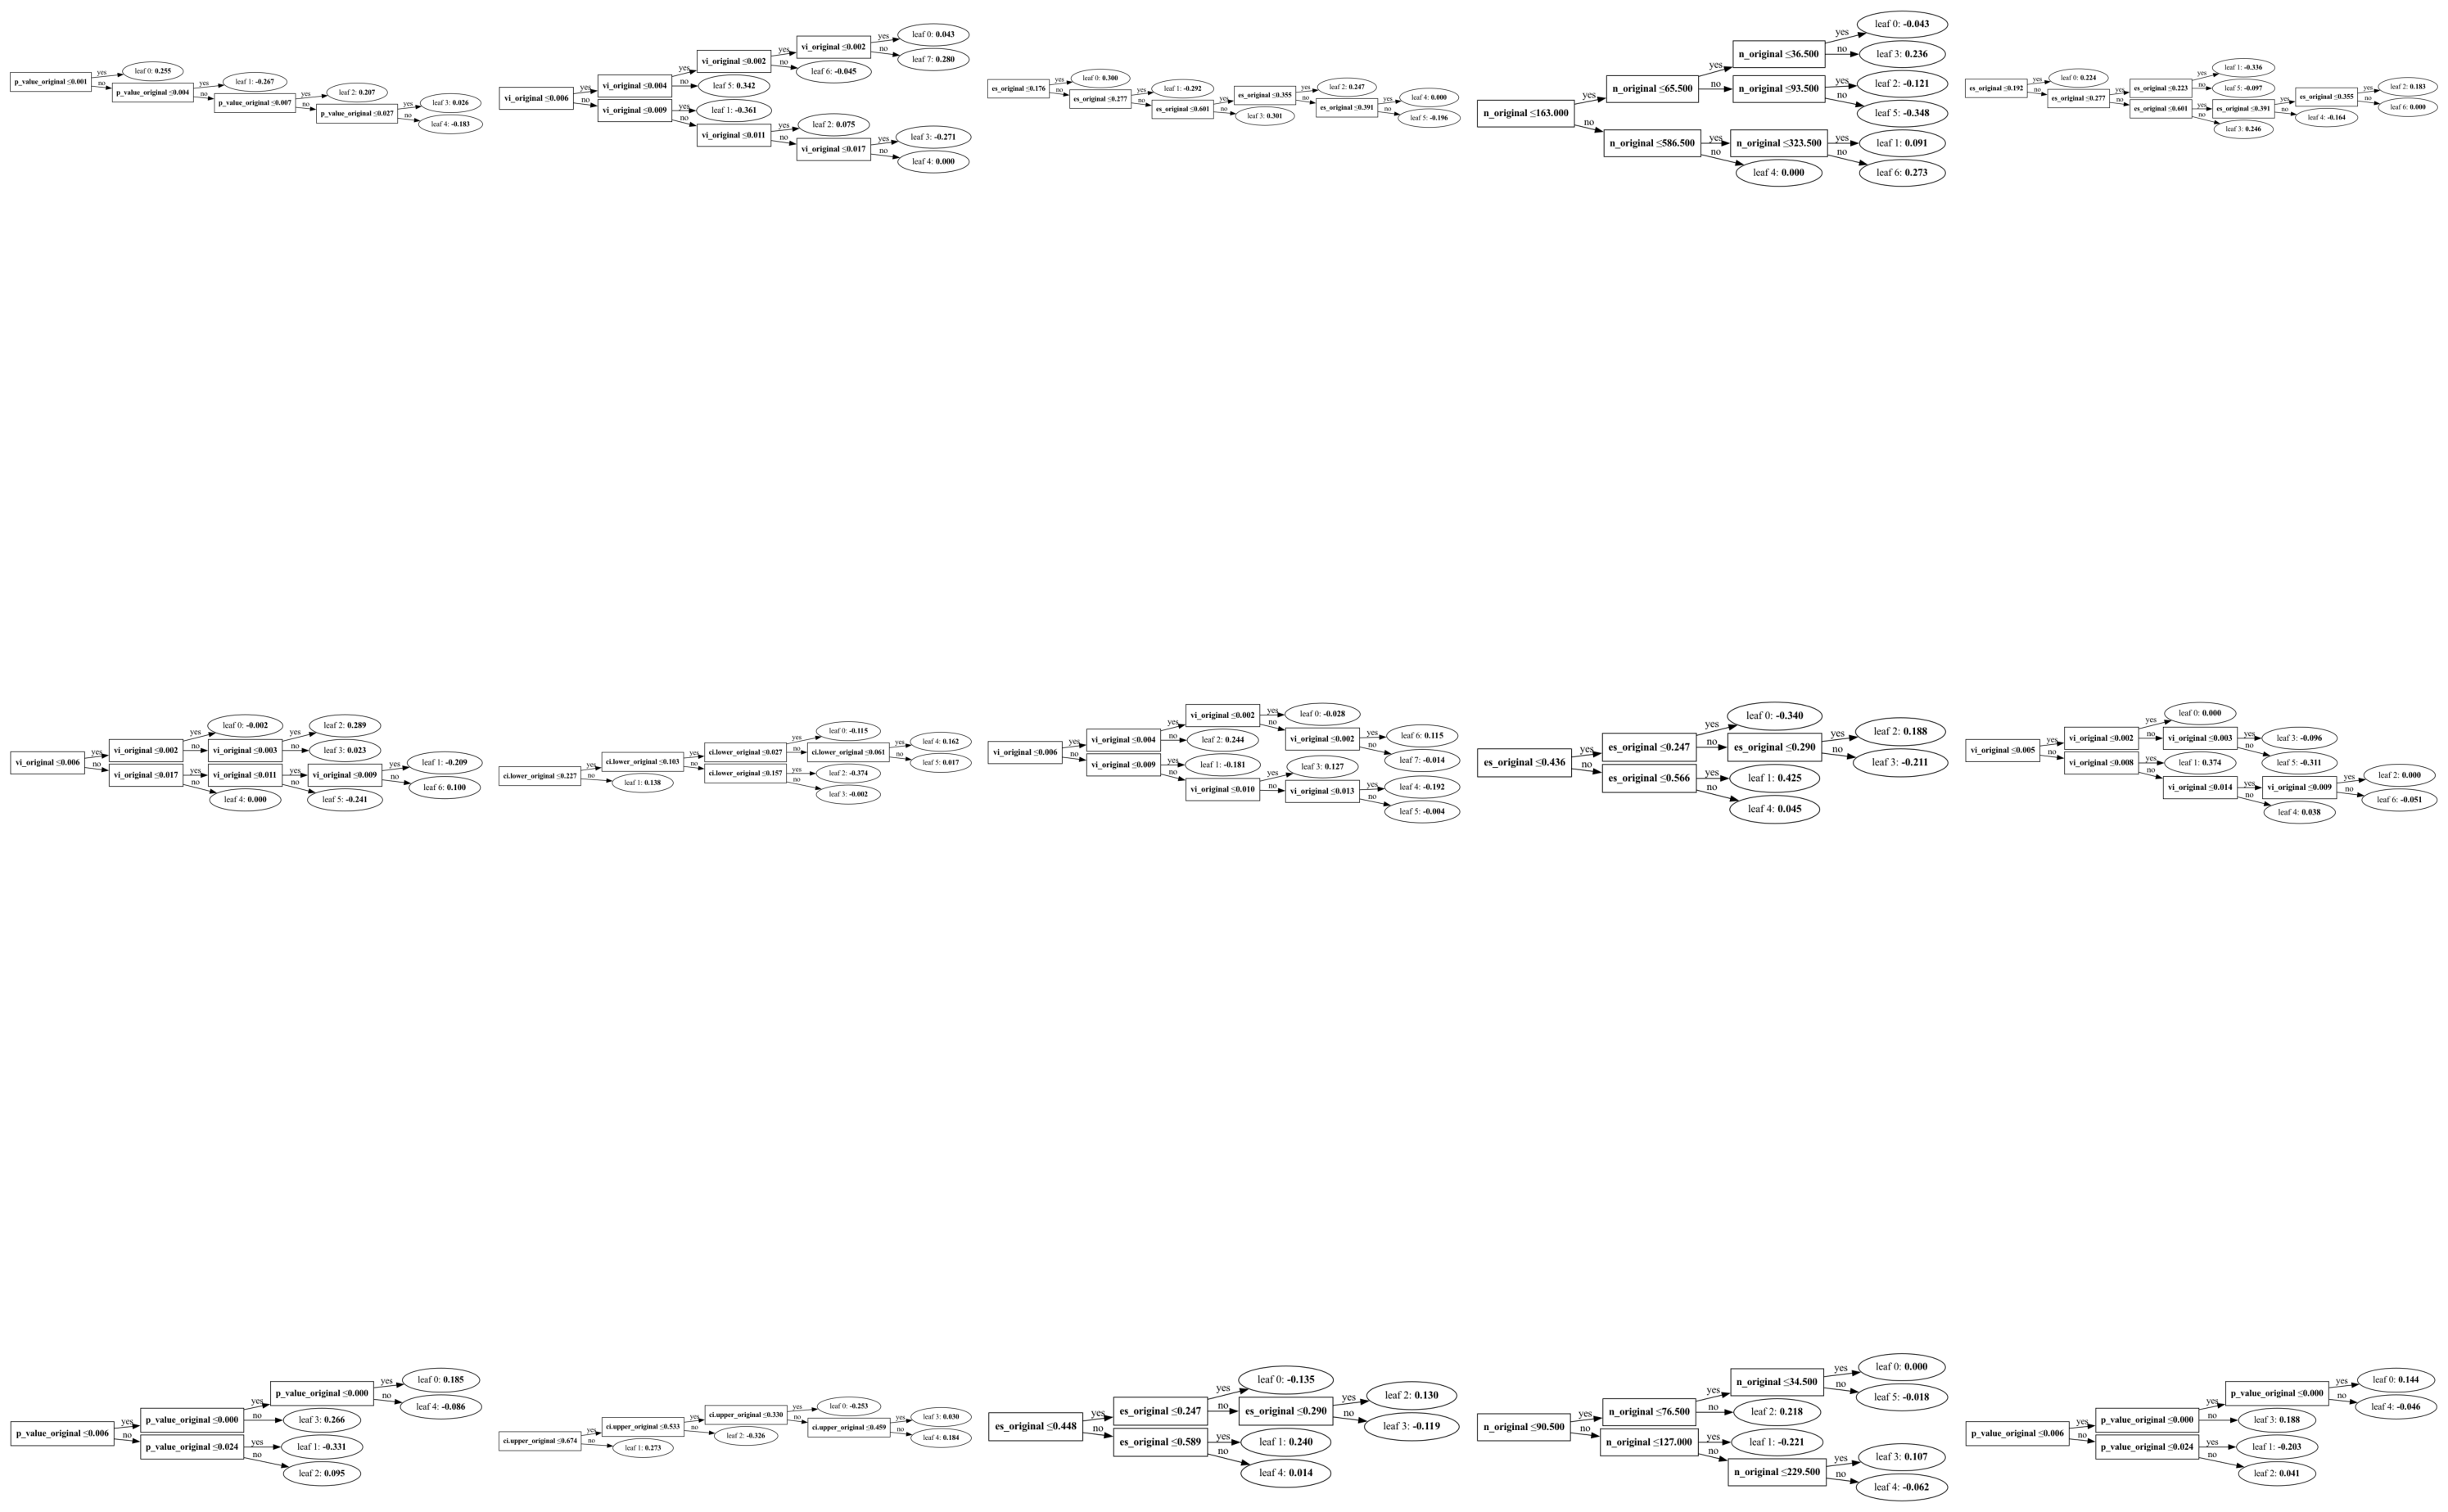

In [17]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from graphviz import Source
from io import BytesIO

num_trees = 15

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 30))

for i in range(num_trees):
    graph = lgb.create_tree_digraph(lgbm_model, tree_index=i)
    
    # This whole png bytestring thing is needed because create_tree_digraph returns graphviz objects
    png_data = Source(graph.source).pipe(format='png')
    
    axes.flatten()[i].imshow(plt.imread(BytesIO(png_data)))
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()

### Tree 7 (a good illustration)

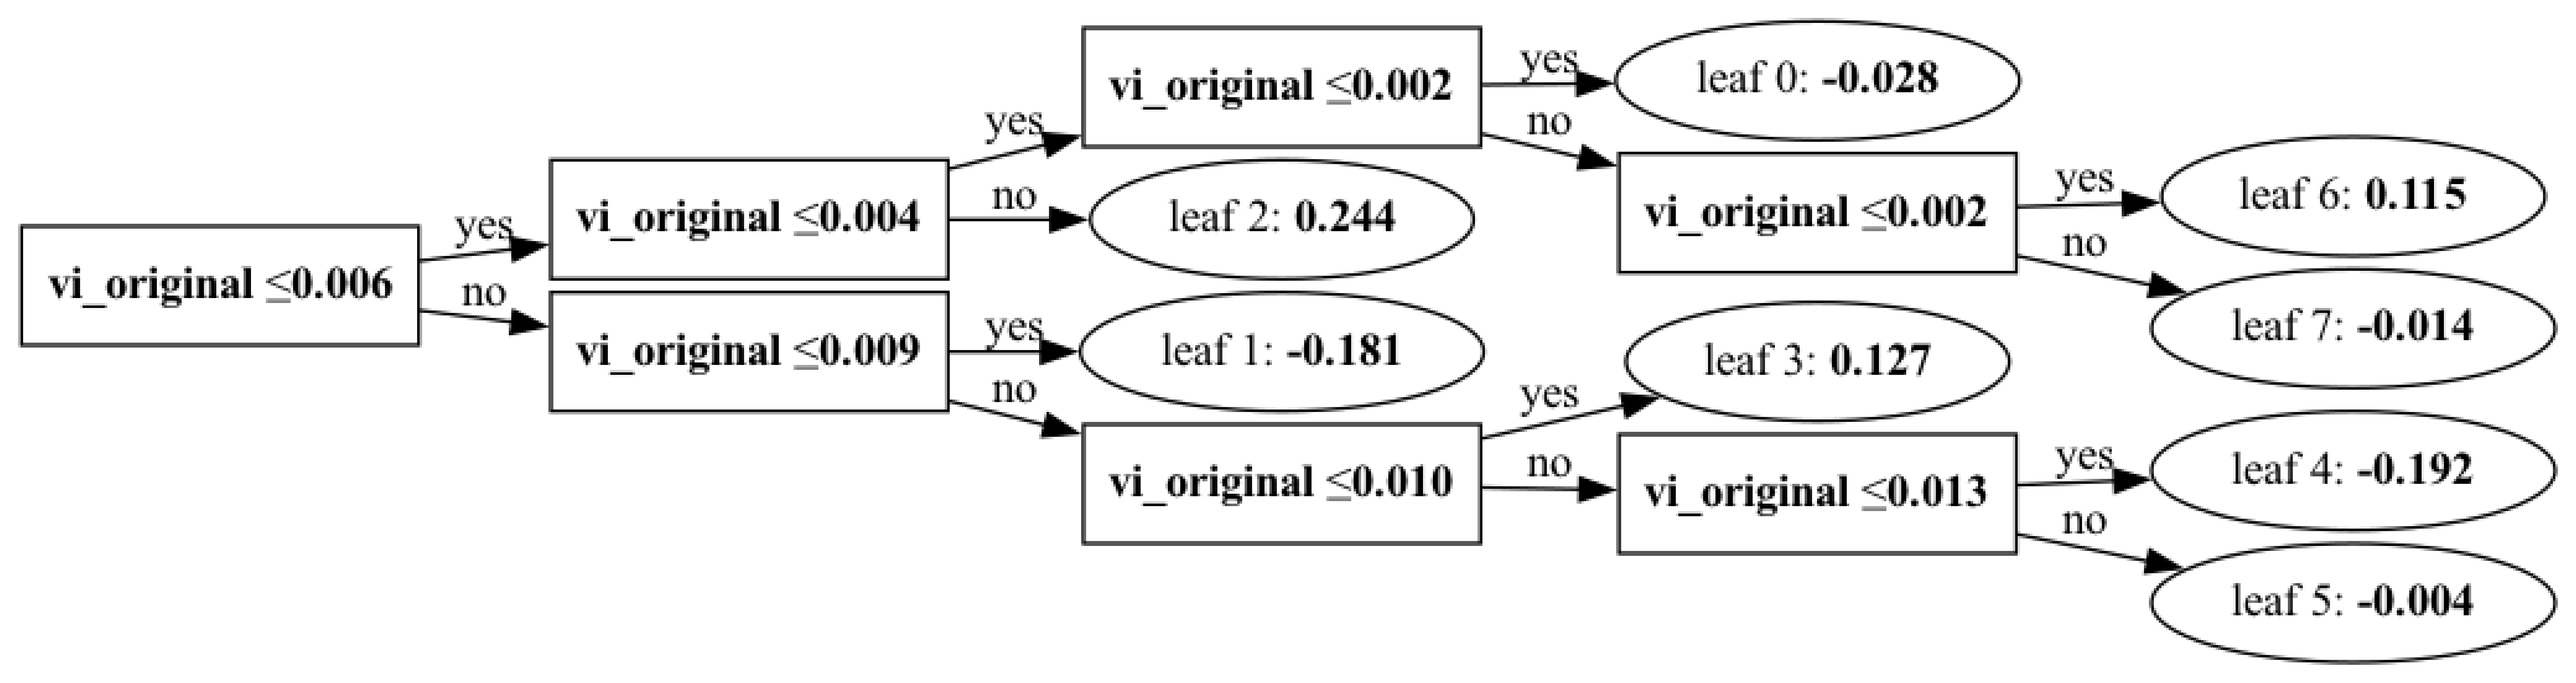

In [32]:

import lightgbm as lgb
import graphviz
import matplotlib.pyplot as plt
from io import BytesIO

plt.figure(figsize=(40, 20), dpi=400)
graph = lgb.create_tree_digraph(lgbm_model, tree_index=7)

# Important to render all of these as an image, 
# the default is PDF and it will have some typographic issues.
png_data = Source(graph.source).pipe(format='png')

plt.axis('off')
plt.imshow(plt.imread(BytesIO(png_data)))
plt.show()



*if this is just saved directly from jupyter, it's going to get slightly blurry for some reason. best way is to directly render it with graphviz like this:*

In [ ]:
graph = lgb.create_tree_digraph(lgbm_model, tree_index=7)

graph.render("plots/tree_7", format="png", cleanup=True)